# MAPseq Data Analysis

In this notebook, we will take the combined bulk RNAseq from all MAPseq target areas. 

## Imports

In [1]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling barcode tags with letters and numbers. 
from natsort import natsorted

# Allowing to run from git. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

gitpath=os.path.expanduser("~/git/cshlwork")
sys.path.append(gitpath)

from mapseq.core import * 
from cshlwork.utils import dataframe_to_seqlist, write_fasta_from_df, run_command_shell, NonZeroReturnException, setup_logging
from alignment.bowtie import run_bowtie, make_bowtie_df, make_adjacency_df

print("Done")

Done


## Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the barcode (SSI) sequences for different target areas, and a standard sample info Excel spreadsheet. 


In [2]:
cp = get_default_config()
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/project/mapseq/M205test/Mseq205_sampleinfo.xlsx')
barcodes = os.path.expanduser('~/project/mapseq/M205test/barcode_v2.txt')
outdir = os.path.expanduser('~/project/mapseq/M205jupout')
infiles = [
    os.path.expanduser('~/project/mapseq/M205test/M205_HZ_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M205test/M205_HZ_S1_R2_001.fastq.gz')
          ]

In [3]:
sampdf = load_sample_info(cp, sampleinfo)
# extract list of actually used primers.
rtlist = list(sampdf.rtprimer.dropna())
# make barcode handler objects
bcolist = load_barcodes(cp, barcodes, labels=rtlist, outdir=outdir)
print(len(bcolist))
sampdf = sampdf[sampdf['rtprimer'].notna()]
of = f'{outdir}/sampleinfo.tsv'
sampdf.to_csv(of, sep='\t')
sampdf

26


,usertube,ourtube,samplename,siteinfo,rtprimer,brain,col_num
1,OB,1,Olfactory Bulb,NaN,1,YW143,1
2,ACB,2,ACB,NaN,2,YW143,2
3,AI,3,AI,NaN,3,YW143,3
4,CP,4,CP (dorsal part - can just dissect out the top...,NaN,4,YW143,4
5,MTN,5,MTN,NaN,5,YW143,5
6,BLAa,6,BLAa,NaN,6,YW143,6
7,PIR,7,Piriform Cortex,NaN,7,YW143,7
8,VTA,8,VTA,NaN,8,YW143,8
9,TeA,9,TeA,NaN,9,YW143,9
10,ENTl,10,ENTl,NaN,10,YW143,10


In [4]:
# handle all the input. usually takes ~25 minutes
process_fastq_pair(cp, infiles[0], infiles[1], bcolist, outdir=outdir, force=False)
!ls ~/project/mapseq/M205jupout/

2023-04-16 22:36:05,904 (UTC) [ INFO ] core.py:607 root.check_output(): all output exists.
2023-04-16 22:36:05,905 (UTC) [ INFO ] core.py:618 root.process_fastq_pair(): output_exists=True force=False
2023-04-16 22:36:05,906 (UTC) [ INFO ] core.py:688 root.process_fastq_pair(): all output exists and force=False. Not recalculating.


BC1.32.fasta         BC16.spike.seq.fasta BC26.spike.btdf.tsv
BC1.fasta            BC16.tsv             BC26.spike.seq.fasta
BC1.real.bowtie      BC17.fasta           BC26.tsv
BC1.real.btdf.tsv    BC17.tsv             BC3.fasta
BC1.real.seq.fasta   BC18.fasta           BC3.real.bowtie
BC1.tsv              BC18.tsv             BC3.real.seq.fasta
BC10.fasta           BC19.fasta           BC3.tsv
BC10.tsv             BC19.tsv             BC4.32.fasta
BC11.fasta           BC2.fasta            BC4.fasta
BC11.tsv             BC2.tsv              BC4.lone.tsv
BC12.fasta           BC20.fasta           BC4.real.tsv
BC12.tsv             BC20.tsv             BC4.spike.tsv
BC13.fasta           BC21.fasta           BC4.tsv
BC13.tsv             BC21.tsv             BC5.fasta
BC14.fasta           BC22.fasta           BC5.tsv
BC14.tsv             BC22.tsv             BC6.fasta
BC15.fasta           BC23.fasta           BC6.tsv
BC15.tsv             BC23.tsv             BC7.fasta
BC16.fasta           BC2

In [14]:
tdflist = []
cdflist = []
outcdf = None
for bch in bcolist:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    of = f'{dirname}/{base}.tsv'
    seqdf = make_fasta_df(cp, bch.filename)
    cdf = make_counts_df(cp, seqdf, bc_label=bch.label)  
    cdflist.append(cdf)
    if bch.label == 'BC16':
        outcdf = cdf
    threshold = calculate_threshold(cp, cdf)
    tdf = threshold_counts(cp, cdf)
    tdf['counts'] = 1
    tdf['sequence'] = tdf['sequence'].str[:32]
    bch.dataframe = make_counts_df(cp, tdf)
    tdflist.append(tdf)
alldf = BarCodeHandler.merge_counts(cp, tdflist)
alldf['logcounts'] = np.log(alldf.counts)
alldf 

2023-04-16 23:00:12,542 (UTC) [ INFO ] core.py:325 root.make_fasta_df(): kept 7341 sequences out of 7342
2023-04-16 23:00:12,547 (UTC) [ INFO ] core.py:299 root.make_counts_df():                                           sequence
0     TAAATGGACAACATCGTCCTAGGAATGAGTTCGGTCTACACCGT
1     ACCTGATGGCTGCTTACTTACTGCCGTCAGTCGGTGTCACCACT
2     GCCTAGGAACCACTAAGTGCGTAACGTCAGTCTATGCTTATGTT
3     ATTTTTACTCGCTCGAGAAGCAAACGTCAGTCGAACGCTTACCC
4     CCGTTGGGCGTAGTGGAACAAGAATGATGTTTAGGAACCGGGAT
...                                            ...
7336  TCAACAGCGTTTTGTGTACTAGCGTCAGTCTCACATGATGCCCA
7337  GATATGTATCGCTGCACTCCCAGTCGTCAGTCGATCGAGCTAGC
7338  AGGCTTGTCGTGCTAAGTCGCGGTTGGCGCTCTTACTAGCTTGA
7339  CTTGGATTTAATTGCTAATTTCTTCGTCAGTCTAACGGGGGCAC
7340  AGCCGGATAATAGTTGTTTGGTGCCGTCAGTCGGAATTATGGTT

[7341 rows x 1 columns]
2023-04-16 23:00:12,558 (UTC) [ INFO ] core.py:372 root.threshold_counts(): thresh = 2
2023-04-16 23:00:12,562 (UTC) [ INFO ] core.py:299 root.make_counts_df():                        

2023-04-16 23:00:23,169 (UTC) [ INFO ] core.py:325 root.make_fasta_df(): kept 108676 sequences out of 108678
2023-04-16 23:00:23,186 (UTC) [ INFO ] core.py:299 root.make_counts_df():                                             sequence
0       AAGATCTCCTTTCCCCGGTCCTTCTCTTTATCAACGCGTGGTTT
1       CTTCTAGGCAAGCGTGGCTTTATCCACATACCAAGATGTTCTTT
2       TGAACAGAAGTGGTGGGGGAAATACGTCAGTCGTACAGCCGGTA
3       CGTTTCGTCTTTCAGATCGGGGACTTGTTATCAGACCTAGACCG
4       GGTCGCGCCATTGTACGGCGCCTCGGTGTACTTAACCTAACCGG
...                                              ...
108671  CCTGGGGGGAATAAGACATCTCGTCTGAGATTTTGCAAATTCCA
108672  TTTATATGGGGCCATCTGAATTCTTCGCATTTGACCAGAGTTTA
108673  ATCATTTTAGGGTGAAACGTCAGTAAACTCCGTTTGGCAAACAG
108674  CAAATCTGCTACAGGTACGAATAAACATAGCTTGGTACAGATCT
108675  GCTCCCCGGCTCTACCAGATGTCATAGTCCTTTAGTACCTCCTC

[108676 rows x 1 columns]
2023-04-16 23:00:23,262 (UTC) [ INFO ] core.py:372 root.threshold_counts(): thresh = 2
2023-04-16 23:00:23,281 (UTC) [ INFO ] core.py:299 root.make_counts

2023-04-16 23:00:24,643 (UTC) [ INFO ] core.py:325 root.make_fasta_df(): kept 5915 sequences out of 5915
2023-04-16 23:00:24,645 (UTC) [ INFO ] core.py:299 root.make_counts_df():                                           sequence
0     GATTGGCTCGCGCCCGCGTCATAGCGTCAGTCTGCTGTTGACTG
1     TGAACAGGGAAAGAACTTGGCGCTCGTCAGTCTAAAAAGGTATA
2     CAAATGTGTCTTAGTCCGTACTTCTTTGCGTTTCAAGACTCGCA
3     CCTTATGCAGGCTCTTTTCGACTAAACCCGCTAAGAAAGGCTCG
4     GTGGTTTGAGATAGGGCCCGCCTAGGGGTACCTGTAGCCAAGGT
...                                            ...
5910  ATAAAACCTAAGTCTCTCCTCTTACGTCAGTCCATAGGCGGAAG
5911  ATAGAGTAGTCATTCTACTTCAGGTTCGTACTCCAGGGCATAGC
5912  CGTATTACATAGCTTCAAGTGCTTAAAACCTTTTCGCAGACACC
5913  AAGTAAACTCGGCGGGATTTAAAGAATTTCCTTCGAGGTAGGGA
5914  ACTGTTGGCCGTATTTTGGCCTACTAGTATCTCTATCGTCAAAA

[5915 rows x 1 columns]
2023-04-16 23:00:24,655 (UTC) [ INFO ] core.py:372 root.threshold_counts(): thresh = 2
2023-04-16 23:00:24,658 (UTC) [ INFO ] core.py:299 root.make_counts_df():                        

2023-04-16 23:01:55,088 (UTC) [ INFO ] core.py:325 root.make_fasta_df(): kept 6550648 sequences out of 6550830
2023-04-16 23:01:55,550 (UTC) [ INFO ] core.py:299 root.make_counts_df():                                              sequence
0        CCCAGCTTCTTTATAAGAATAAACGTATTTTCTTTTGGAAGTTA
1        GGAAGCCCTCGGGGGAGGCGTTCGGGTAGCTTCGGGGGTGCCGT
2        CTGTTAAAGTTCGGTATATCGGAGTACACATTTTGTTTTGTTCG
3        ACATCTGATGATTACCACCCTTGGGGTATCCTCATTAAGGCGCT
4        CACCGATCATGCTTTGCAATGTTATTCGATTCCAAGGTCTGATA
...                                               ...
6550643  TTGGGGCTGATTGTACGCAAATTTTTAATACCGGGGTAAGTGCT
6550644  GCAGGCTGGGTGTATAGGGGGCGTGGTAGCCTGAGTGAAAATTA
6550645  CATTTCTCCGACGTTGACACACGACGTAATCTGACCAGAGTTCA
6550646  GTGGTGAGCATACGTTGGGGGCCGAGCGGGTTGACACGAACTGG
6550647  TTAACCGGCTGACATCGGTTTGTATGTAGCTCAACATTGTAGGT

[6550648 rows x 1 columns]
2023-04-16 23:02:02,946 (UTC) [ INFO ] core.py:372 root.threshold_counts(): thresh = 2
2023-04-16 23:02:04,534 (UTC) [ INFO ] core.py:299 r

2023-04-16 23:02:06,425 (UTC) [ INFO ] core.py:325 root.make_fasta_df(): kept 7156 sequences out of 7159
2023-04-16 23:02:06,428 (UTC) [ INFO ] core.py:299 root.make_counts_df():                                           sequence
0     AGGCATTTACAGGGCGATTGGATACGTCAGTCTGCTCGCGTTGG
1     TATTTGGGACCAAGACGAACAGGGCGTCAGTCAGCGACGCGTGC
2     GCATAGGCACGCCTAATGTAATGCCGTCAGTCACACAAAGTTAA
3     GCATTCTTGTATCAGGGGAAGCAGTGCGAGCCTAAAGGTCACAC
4     TATTAGCTATTATTCTATGATTCTCGTCAGTCCAGCAACTAAAT
...                                            ...
7151  CTGTTCTACTGCGGGTATGGATCCGTCAGTCTGCTTTTTCGGAT
7152  TGTGTACCACAAAAGCCGAGGGGTTTGGCTTTACCAGTGTGTCC
7153  ATGGGCACATTGCCCAGTGCGGTAGTGTTCTTACGGCCGTGAGT
7154  ATGACATGGGTTAACGGTTCCTCGCGTCAGTCGTTTCTACTGAA
7155  TTACAACTTCGGCTGATCTGCAGGCGTCAGTCAGGTGGTCAGTA

[7156 rows x 1 columns]
2023-04-16 23:02:06,438 (UTC) [ INFO ] core.py:372 root.threshold_counts(): thresh = 2
2023-04-16 23:02:06,443 (UTC) [ INFO ] core.py:299 root.make_counts_df():                        

2023-04-16 23:02:32,230 (UTC) [ INFO ] core.py:325 root.make_fasta_df(): kept 1876 sequences out of 1876
2023-04-16 23:02:32,282 (UTC) [ INFO ] core.py:299 root.make_counts_df():                                           sequence
0     GTCTGCCAGTATTCTCTGGGATTTCGTCAGTCACGGATTACGCT
1     GCCTATCTTGTTTTTCAGTCGCCTCTGTTGTCCAAGAACCCGAA
2     GTGCAGGGTATTGGAAGTGCATCCCGTCAGTCTCCCCGACGTTA
3     ACATGAGGATTTCATTGAACGGAACGTCAGTCTTATCGGGTTTG
4     ATAATGGGAGGTCGATTGAGGCATAACTCTCCCGCTTGTTATTA
...                                            ...
1871  TAGATCACCTGTTCATGCAATCTGCGTCAGTCATACCATCTCCG
1872  TAAGTTAGTGCGACCATTCACCGGATGGGTGGGGTTGAGATACC
1873  ACATATGGTGGGAGGGCCGAGTTGCGTCAGTCTTAGCCTGAAGG
1874  GTCGCTCACCGTTTGGGATGCCACCGTCAGTCTGAAGTTTTAAC
1875  TAGCAGTTTATTATAGTTTACAAACGTCAGTCGTGCTGCTGGGA

[1876 rows x 1 columns]
2023-04-16 23:02:32,290 (UTC) [ INFO ] core.py:372 root.threshold_counts(): thresh = 2
2023-04-16 23:02:32,293 (UTC) [ INFO ] core.py:299 root.make_counts_df():                        

,bc_label,sequence,counts,logcounts
0,BC1,GCTTTACTAAACTCTTCCTTGCCATTGAATTC,1,0.0
1,BC1,AACACCAGCAAGTGGAGGGTTATGCGCGTACT,1,0.0
2,BC1,ATTCTCAGGTAAATGGCGCCGCTTAATTTATC,1,0.0
3,BC1,GTTTCACCCGGTCTGCACGCGCCAGCCACCCG,1,0.0
4,BC1,CTGGAGCTGCGATGTCGTTAACGCCGTCAGTC,1,0.0
...,...,...,...,...
3539371,BC26,TAGCATATTCGGTTGTTGCTCTAACGTCAGTC,1,0.0
3539372,BC26,GGTCTGACACGGGACGCGTGAGGTCGTCAGTC,1,0.0
3539373,BC26,CTACCCTAGCGCGGCGAGTATCCCCGTCAGTC,1,0.0
3539374,BC26,GAGGGAGTCAAAGGGCTGAGGTACCTCCCATC,1,0.0


In [13]:
cdflist

[                                          sequence  counts bc_label
 0     GCTTTACTAAACTCTTCCTTGCCATTGAATTCACCCTGCGCACG       8      BC1
 1     AACACCAGCAAGTGGAGGGTTATGCGCGTACTCCTATACAACAA       7      BC1
 2     ATTCTCAGGTAAATGGCGCCGCTTAATTTATCGACTAATAGGGA       7      BC1
 3     GTTTCACCCGGTCTGCACGCGCCAGCCACCCGATAAGGCATTCT       6      BC1
 4     CTGGAGCTGCGATGTCGTTAACGCCGTCAGTCATATTTACTAAA       6      BC1
 ...                                            ...     ...      ...
 4753  TGTAATACGATGACGCTTTTACGCCGTCAGTCGTAGGTAAATGA       1      BC1
 4754  TGCTCAATTTCTCAGCGTCTCGCCTAGAAACCAAAGTGAGGTGT       1      BC1
 4755  GCCAGTTCTACAGCAGCCCGCCTAAACCTTTTTGATGTAAGCTC       1      BC1
 4756  AATCGCTGCTAACTTTCGGCCGAAAGGGGTTTGCGTAAGATCTC       1      BC1
 4757  CTTGGATTTAATTGCTAATTTCTTCGTCAGTCTAACGGGGGCAC       1      BC1
 
 [4758 rows x 3 columns],
                                             sequence  counts bc_label
 0       TCCAACTTGGGGGGCTTAGCGTATCGATGTCCTACGGTAAACTC       8      BC2
 1

In [12]:
outcdf[outcdf.counts > 2]

,sequence,counts,bc_label
0,CAATATTAGTTCTCACTTGGGTTGATCCGGCCCCCTTATCAAGG,11,BC16
1,TATGCGACCTCCAGCCGATCGTCATGTGTTTTCGCAGTAACAGT,11,BC16
2,TGGAATCGAACTGAGCTGCTGCCAGGGGCTTCGATCTAAGTGCC,10,BC16
3,CTTCCCCGTGACCTTCAATGAGAATTTGCTTTGCCTGCCTGAAT,10,BC16
4,CGTGGCACATGGTACAGTAGTTCTAGCGCTTGGCCGATTAATTG,10,BC16
...,...,...,...
592733,AGGATCTTTTGCGCATAACATATTGATGAGCCGTGAAGCTGCGT,3,BC16
592734,CGTGGAGCACGTTTTGCCGGCCTAGATTAATCCTCCTAAACCCA,3,BC16
592735,GTAATGCGTCCCAGCTTAGTGTGGCCCCGGCTTACGGTGAGGTG,3,BC16
592736,CGGCCGGAATCGGCGCTATCGGGGAGGGTCTTGGACCTGACACT,3,BC16


<AxesSubplot: ylabel='counts'>

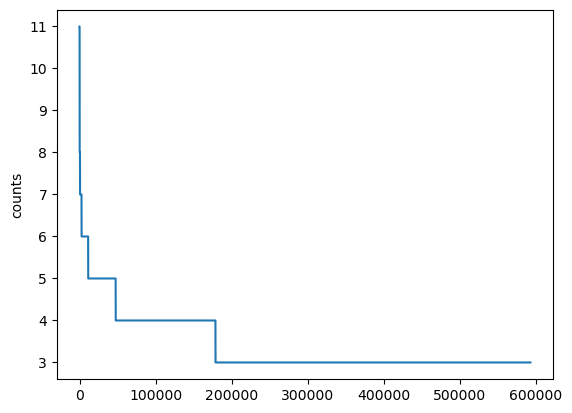

In [8]:
plotdf = outcdf[outcdf.counts > 2]
#plotdf['logcounts'] = np.log(plotdf.counts)
sns.lineplot(data=plotdf, x= plotdf.index, y = 'counts')

In [10]:
#graph = sns.FacetGrid(alldf, col = 'bc_label', hue='counts', col_wrap = 4, row_order='bc_label')
#graph.map(sns.lineplot, y="counts")
#plt.show()

In [17]:
# use BC16  as example 
# need to trim again to 32 length!!

reals =[]
spikes =[]
lones =[]

alldfs = []

for bch in bcolist[:1]:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    
    outfile = trim_fasta(cp, bch.filename, length=32)
    seqdf = make_fasta_df(cp, outfile)
    df = make_counts_df(cp, seqdf, bc_label=bch.label)
    bch.dataframe = df
    print(f'{bch.label} {len(df)}')
    (spikedf, realdf, lonedf) = split_spike_real_lone_barcodes(cp, df)

    realcdf = make_counts_df(cp, realdf)
    spikecdf = make_counts_df(cp, spikedf)
    lonecdf = make_counts_df(cp, lonedf)    
    
    print(realdf)
    
    acrealdf = align_and_collapse(cp, realdf, dirname, base, 'real')
    acspikedf = align_and_collapse(cp, spikedf, dirname, base, 'spike')
    aclonedf = align_and_collapse(cp, lonedf, dirname, base, 'lone')
    
    acrealdf['type'] = 'real'
    acspikedf['type'] = 'spike'
    aclonedf['type'] = 'lone'
    
    outdf = merge_dfs([ acrealdf, acspikedf, aclonedf ])
    outdf['bc_label'] = base
    outdf.sort_values(by = ['type', 'counts'], ascending = [True, False], inplace=True)
    outdf.reset_index(drop=True, inplace=True)
    alldfs.append(outdf)
    
alldfs
    
    #print(reals[0])

2023-04-17 19:28:02,175 (UTC) [ INFO ] core.py:352 root.trim_fasta(): wrote 7342 to /Users/jhover/project/mapseq/M205jupout/BC1.32.fasta
2023-04-17 19:28:02,243 (UTC) [ INFO ] core.py:327 root.make_fasta_df(): kept 7342 sequences out of 7342
2023-04-17 19:28:02,251 (UTC) [ INFO ] core.py:301 root.make_counts_df():                               sequence
0     TAAATGGACAACATCGTCCTAGGAATGAGTTC
1     ACCTGATGGCTGCTTACTTACTGCCGTCAGTC
2     GCCTAGGAACCACTAAGTGCGTAACGTCAGTC
3     ATTTTTACTCGCTCGAGAAGCAAACGTCAGTC
4     CCGTTGGGCGTAGTGGAACAAGAATGATGTTT
...                                ...
7337  TCAACAGCGTTTTGTGTACTAGCGTCAGTCTC
7338  GATATGTATCGCTGCACTCCCAGTCGTCAGTC
7339  AGGCTTGTCGTGCTAAGTCGCGGTTGGCGCTC
7340  CTTGGATTTAATTGCTAATTTCTTCGTCAGTC
7341  AGCCGGATAATAGTTGTTTGGTGCCGTCAGTC

[7342 rows x 1 columns]
2023-04-17 19:28:02,272 (UTC) [ INFO ] core.py:415 root.split_spike_real_lone_barcodes(): initial=3615 spikeins=2639 real=787 lone=94
2023-04-17 19:28:02,273 (UTC) [ INFO ] core.py:301 root.m

BC1 3615
                             sequence  counts bc_label
0    TAAATGGACAACATCGTCCTAGGAATGAGTTC     257      BC1
1    TGTGAGTATCAATTTGTCCGTTTTCATCCACT      78      BC1
2    GCCGTTAAATTACTAGTAACCAGCCCGTCTCC      76      BC1
3    CAATGAGCTTGGGCAAGGGGGCGGGAGTCACT      72      BC1
4    GCTCTCGAGACGTTGTCATAGTATAGGCCCCC      68      BC1
..                                ...     ...      ...
782  TGACGTGGGTATTGTACGTTTGAGGGGCCCTC       1      BC1
783  AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC       1      BC1
784  TGTTCAGTCGAATAACTTTTTTACTTCTGTCT       1      BC1
785  GGGTTTTGGTCGTGGATGGGTGTGCAATCACC       1      BC1
786  TAGGTGTCTTTTTATAGGCTGTTAAGGAGTTC       1      BC1

[787 rows x 3 columns]


2023-04-17 19:28:02,581 (UTC) [ INFO ] bowtie.py:68 root.run_bowtie(): bowtie-build done.
2023-04-17 19:28:02,795 (UTC) [ INFO ] bowtie.py:104 root.run_bowtie(): bowtie done.
2023-04-17 19:28:02,797 (UTC) [ INFO ] core.py:135 root.align_and_collapse(): handle bowtie align file: /Users/jhover/project/mapseq/M205jupout/BC1.real.bowtie
2023-04-17 19:28:02,813 (UTC) [ INFO ] core.py:230 root.get_components(): getting connected components from edgelist len=845
2023-04-17 19:28:02,817 (UTC) [ INFO ] core.py:235 root.get_components(): 758 components.
2023-04-17 19:28:02,818 (UTC) [ INFO ] core.py:141 root.align_and_collapse(): countdf columns are Index(['sequence', 'counts', 'bc_label'], dtype='object')
2023-04-17 19:28:02,819 (UTC) [ INFO ] core.py:189 root.collapse_counts_df(): collapsing countsdf len=787 w/ 758 components.
2023-04-17 19:28:04,146 (UTC) [ INFO ] core.py:216 root.collapse_counts_df(): original len=787 collapsed len=758
2023-04-17 19:28:04,149 (UTC) [ INFO ] core.py:374 root.

[                              sequence  counts bc_label   type
 0     TGTATATCCGGGCTTGAACCGTCAGTCTCGGA       3      BC1   lone
 1     TCGCGACTTCGCGCTCAGAATGGGAGGTATAG       3      BC1   lone
 2     GATCGCTATCTGTGTGTGTATAGCTCCGTCAG       3      BC1   lone
 3     GGGGATGTAAGTAAATTCGAGGCGACGGCTGG       2      BC1   lone
 4     ATCTATCAGTTCCCGCTGGCAACGCGTAATGA       2      BC1   lone
 ...                                ...     ...      ...    ...
 1384  GTTGAGAAGCTACTACGGTACAAGCGTCAGTC       2      BC1  spike
 1385  AGTTGGTTATGTCTCACATAGTAACGTCAGTC       2      BC1  spike
 1386  ATGCGTATTTCGCATTTGGAACAGCGTCAGTC       2      BC1  spike
 1387  CTTGCATTTTACAGCTTTCTGGACCGTCAGTC       2      BC1  spike
 1388  AGTGTGCTTTATATGTGTTTGACCCGTCAGTC       2      BC1  spike
 
 [1389 rows x 4 columns]]

In [18]:
bch = bcolist[3]
print(bch.label)
base = 'BC3'
aligner = cp.get('bcfasta','tool')
of = os.path.join(outdir , f'{base}.real.seq.fasta')
logging.debug(f'make fasta for {aligner} = {of}') 
seqfasta = write_fasta_from_df(cp, realdf, outfile=of)
of = os.path.join(outdir , f'{base}.real.{aligner}')
afile = run_bowtie(cp, seqfasta, of, tool=aligner )  
btdf = make_bowtie_df(afile)
btdf

2023-04-17 19:31:27,030 (UTC) [ INFO ] utils.py:632 root.dataframe_to_seqlist(): made list of 787 SeqRecords
2023-04-17 19:31:27,036 (UTC) [ INFO ] bowtie.py:35 root.run_bowtie(): running allxall bowtie on /Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta -> /Users/jhover/project/mapseq/M205jupout/BC3.real.bowtie
2023-04-17 19:31:27,037 (UTC) [ INFO ] bowtie.py:60 root.run_bowtie(): running ['bowtie-build', '/Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta', '/Users/jhover/project/mapseq/M205jupout/indexes/BC3.real.seq']


BC4


2023-04-17 19:31:27,250 (UTC) [ INFO ] bowtie.py:68 root.run_bowtie(): bowtie-build done.
2023-04-17 19:31:27,472 (UTC) [ INFO ] bowtie.py:104 root.run_bowtie(): bowtie done.


,name_read,strand,name_align,offset,seq,quals,ceil,mm_desc
0,0,+,0,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
1,0,+,391,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,13:A>T
2,1,+,1,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
3,1,+,694,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,6:C>T
4,2,+,2,0,GCCGTTAAATTACTAGTAACCAGCCCGTCTCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
...,...,...,...,...,...,...,...,...
840,783,+,783,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
841,783,+,47,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,11:G>A
842,784,+,784,0,TGTTCAGTCGAATAACTTTTTTACTTCTGTCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
843,785,+,785,0,GGGTTTTGGTCGTGGATGGGTGTGCAATCACC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN


In [19]:
cp = get_default_config()
allfiles = [
'/Users/jhover/project/mapseq/M205testout/BC1.all.tsv','/Users/jhover/project/mapseq/M205testout/BC21.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC10.all.tsv','/Users/jhover/project/mapseq/M205testout/BC22.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC11.all.tsv','/Users/jhover/project/mapseq/M205testout/BC23.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC12.all.tsv','/Users/jhover/project/mapseq/M205testout/BC24.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC13.all.tsv','/Users/jhover/project/mapseq/M205testout/BC25.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC14.all.tsv','/Users/jhover/project/mapseq/M205testout/BC26.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC15.all.tsv','/Users/jhover/project/mapseq/M205testout/BC3.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC16.all.tsv','/Users/jhover/project/mapseq/M205testout/BC4.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC17.all.tsv','/Users/jhover/project/mapseq/M205testout/BC5.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC18.all.tsv','/Users/jhover/project/mapseq/M205testout/BC6.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC19.all.tsv','/Users/jhover/project/mapseq/M205testout/BC7.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC2.all.tsv','/Users/jhover/project/mapseq/M205testout/BC8.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC20.all.tsv','/Users/jhover/project/mapseq/M205testout/BC9.all.tsv'    
]
bcm, sbcm = process_merge_targets(cp, allfiles, outdir=None)
bcm

2023-04-17 19:31:34,962 (UTC) [ INFO ] core.py:700 root.process_merge_targets(): ['/Users/jhover/project/mapseq/M205testout/BC1.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC21.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC10.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC22.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC11.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC23.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC12.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC24.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC13.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC25.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC14.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC26.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC15.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC3.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC16.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC4.all.tsv', '/Users/j

bc_label,BC1,BC2,BC3,BC4,BC5,BC6,BC7,BC8,BC9,BC10,...,BC16,BC17,BC18,BC19,BC20,BC21,BC22,BC23,BC24,BC25
0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
1,0,0,0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,51,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40172,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0
40173,0,0,0,0,0,0,0,0,0,0,...,13,0,0,0,0,0,0,0,0,0
40174,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,0,0
